In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import copy

import pandas as pd
from torch.utils.data import dataloader, Dataset
from tqdm.auto import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Load Our Data

In [5]:
mali = np.load('mal_collect.npy')

In [6]:
mali.shape

(2915, 8, 10)

In [7]:
benign = np.load('benign_collect.npy')

In [8]:
benign.shape

(3085, 8, 10)

In [9]:
benign

array([[[5, 2, 1, ..., 1, 1, 0],
        [3, 1, 1, ..., 2, 1, 0],
        [1, 1, 1, ..., 1, 1, 0],
        ...,
        [5, 1, 1, ..., 1, 1, 0],
        [3, 4, 5, ..., 6, 1, 0],
        [3, 1, 2, ..., 1, 1, 0]],

       [[3, 1, 1, ..., 1, 1, 0],
        [3, 1, 1, ..., 1, 1, 0],
        [3, 1, 1, ..., 1, 1, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 0],
        [5, 3, 3, ..., 1, 1, 0],
        [3, 1, 4, ..., 1, 1, 0]],

       [[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 0],
        ...,
        [3, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 0],
        [3, 1, 1, ..., 1, 1, 0]],

       ...,

       [[5, 1, 1, ..., 1, 1, 0],
        [3, 1, 1, ..., 1, 1, 0],
        [1, 2, 3, ..., 1, 1, 0],
        ...,
        [3, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 0],
        [4, 1, 1, ..., 1, 1, 0]],

       [[5, 1, 3, ..., 1, 1, 0],
        [2, 1, 1, ..., 1, 1, 0],
        [2, 1, 1, ..., 1, 1, 0],
        ...,
        [4, 1, 1, ..., 

In [10]:
benign_no_label = benign[:, :, :-1]
benign_no_label = benign_no_label / 10.0

In [11]:
mali_no_label = mali[:, :, :-1]
mali_no_label = mali_no_label / 10.0

In [12]:
mali_no_label

array([[[0.2, 0.1, 0.1, ..., 0.3, 0.1, 0.1],
        [0.4, 0.1, 0.1, ..., 0.2, 0.1, 0.1],
        [0.3, 0.1, 0.1, ..., 0.2, 0.1, 0.1],
        ...,
        [0.4, 0.1, 0.1, ..., 0.3, 0.1, 0.1],
        [0.2, 0.3, 0.1, ..., 0.1, 0.1, 0.1],
        [0.5, 0.1, 0.2, ..., 0.3, 0.1, 0.1]],

       [[0.5, 0.1, 0.1, ..., 0.3, 0.1, 0.1],
        [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
        [0.8, 0.4, 0.5, ..., 0.7, 0.3, 0.1],
        ...,
        [0.6, 1. , 1. , ..., 1. , 1. , 0.7],
        [0.8, 1. , 1. , ..., 0.7, 0.8, 0.1],
        [1. , 0.5, 0.7, ..., 0.8, 0.9, 0.1]],

       [[0.3, 0.4, 0.4, ..., 0.3, 0.3, 0.1],
        [0.3, 0.6, 0.4, ..., 0.3, 0.4, 0.1],
        [0.4, 0.1, 0.1, ..., 0.2, 0.1, 0.1],
        ...,
        [0.5, 0.1, 0.1, ..., 0.2, 0.1, 0.1],
        [1. , 0.1, 0.1, ..., 0.5, 0.4, 0.1],
        [0.3, 1. , 0.3, ..., 0.5, 0.1, 0.4]],

       ...,

       [[0.3, 0.1, 0.1, ..., 0.2, 0.1, 0.1],
        [0.1, 0.1, 0.1, ..., 0.3, 0.1, 0.1],
        [0.1, 0.1, 0.1, ..., 0.3, 0.1, 0.1

In [13]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

train_df, val_df = train_test_split(
  benign_no_label,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

In [14]:
from torch.utils.data import DataLoader

batch_size = 1
train_ds = [torch.tensor(s).squeeze(-1).float() for s in train_df]
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

test_ds = [torch.tensor(s).squeeze(-1).float() for s in test_df]
test_dl = DataLoader(test_ds, 1, shuffle=True, num_workers=2, pin_memory=True)

val_ds = [torch.tensor(s).squeeze(-1).float() for s in val_df]
val_dl = DataLoader(val_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

test_mal_ds = [torch.tensor(s).squeeze(-1).float() for s in mali_no_label]
test_mal_dl = DataLoader(test_mal_ds, 1, shuffle=True, num_workers=2, pin_memory=True)

In [15]:
for i, s in enumerate(train_dl):
    print(s.size())
    break

torch.Size([1, 8, 9])


# LSTM

In [16]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

#     return hidden_n.reshape((self.n_features, self.embedding_dim))
    return hidden_n.reshape((x.size(0), 1, self.embedding_dim))
#     return hidden_n

In [17]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(1, self.seq_len, 1)
#     print(x.size())
#     x = x.repeat(self.seq_len, self.n_features)
#     x = x.reshape((self.n_features, self.seq_len, self.input_dim))
#     print(x.size())
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
#     x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [18]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
#     print(x.size())
    
    return x

In [19]:
seq_len, n_features = 8, 9
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [20]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [21]:
device

device(type='cuda')

In [22]:
model, history = train_model(
  model, 
  train_dl, 
  val_dl, 
  n_epochs=20
)

Epoch 1: train loss 3.162719339086844 val loss 3.129338313302686
Epoch 2: train loss 3.134096293141149 val loss 3.1230125519537157
Epoch 3: train loss 3.1363408879229895 val loss 3.1627537831183403
Epoch 4: train loss 3.1364318807328773 val loss 3.1559502467032403
Epoch 5: train loss 3.131764788740378 val loss 3.1287545061880544
Epoch 6: train loss 3.1340632838297218 val loss 3.1546428488146874
Epoch 7: train loss 3.1350161657589797 val loss 3.1408153699290366
Epoch 8: train loss 3.13355544152649 val loss 3.1155358872106
Epoch 9: train loss 3.133800326868562 val loss 3.1213336321615404
Epoch 10: train loss 3.133454930409505 val loss 3.146404008326992
Epoch 11: train loss 3.1310320158072047 val loss 3.1080806966750854
Epoch 12: train loss 3.132446610204688 val loss 3.13177142489341
Epoch 13: train loss 3.1330871659549113 val loss 3.0880053712475686
Epoch 14: train loss 3.1300555057511086 val loss 3.13320873168207
Epoch 15: train loss 3.1335505829295704 val loss 3.1847350447408616
Epoch 

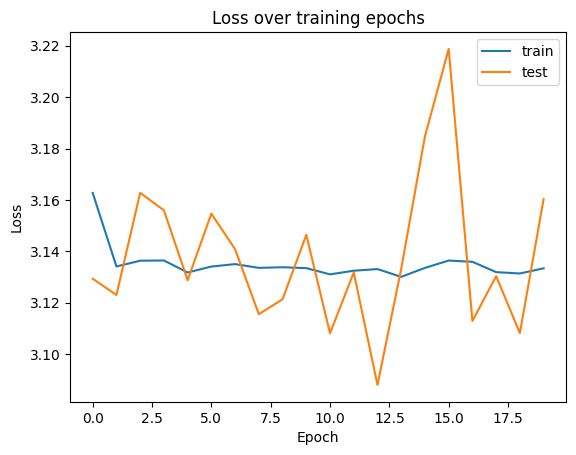

In [23]:
import matplotlib.pyplot as plt

ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [24]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

/tmp/ipykernel_31714/2751841521.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);


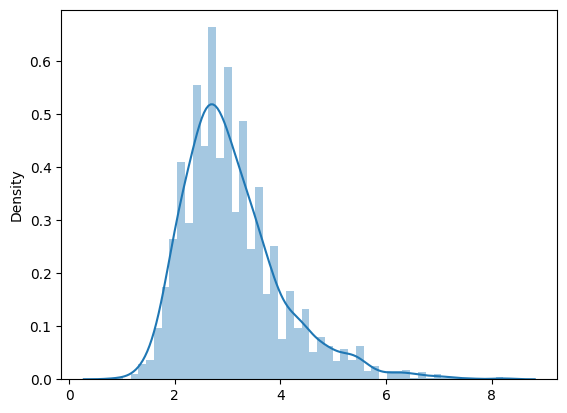

In [25]:
import seaborn as sns

_, losses = predict(model, train_dl)

sns.distplot(losses, bins=50, kde=True);

In [26]:
THRESHOLD = 6

In [27]:
train_correct = sum(l <= THRESHOLD for l in losses)
train_accuracy = train_correct/len(train_dl)
print(f'Train accuracy: {train_accuracy}')

Train accuracy: 0.9862700228832952


/tmp/ipykernel_31714/1060344979.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(benign_pred_losses, bins=50, kde=True);


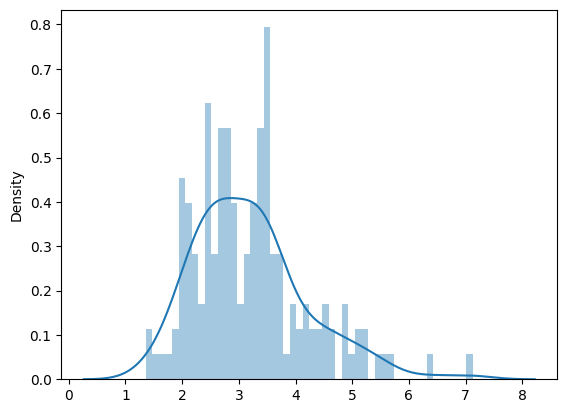

In [28]:
benign_predictions, benign_pred_losses = predict(model, test_dl)
sns.distplot(benign_pred_losses, bins=50, kde=True);

In [29]:
benign_correct = sum(l <= THRESHOLD for l in benign_pred_losses)
print(f'Correct benign predictions: {benign_correct}/{len(test_dl)}')

Correct benign predictions: 151/153


In [30]:
benign_accuracy = benign_correct/len(test_dl)
benign_accuracy

0.9869281045751634

/tmp/ipykernel_31714/2290286343.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mal_pred_losses, bins=50, kde=True);


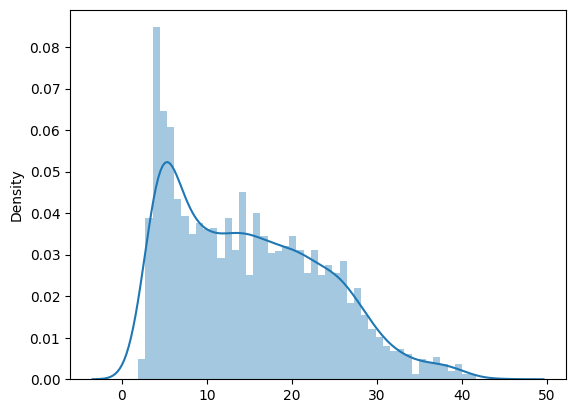

In [31]:
mal_predictions, mal_pred_losses = predict(model, test_mal_dl)
sns.distplot(mal_pred_losses, bins=50, kde=True);

In [32]:
mal_correct = sum(l > THRESHOLD for l in mal_pred_losses)
print(f'Correct anomaly predictions: {mal_correct}/{len(test_mal_dl)}')

Correct anomaly predictions: 2319/2915


In [33]:
mal_accuracy = (mal_correct/len(test_mal_dl))*100
mal_accuracy

79.5540308747856

In [34]:
test_accuracy = (mal_correct+benign_correct)/(len(test_mal_dl)+len(test_dl))
print(f'Total test accuracy: {test_accuracy}')

Total test accuracy: 0.8050847457627118


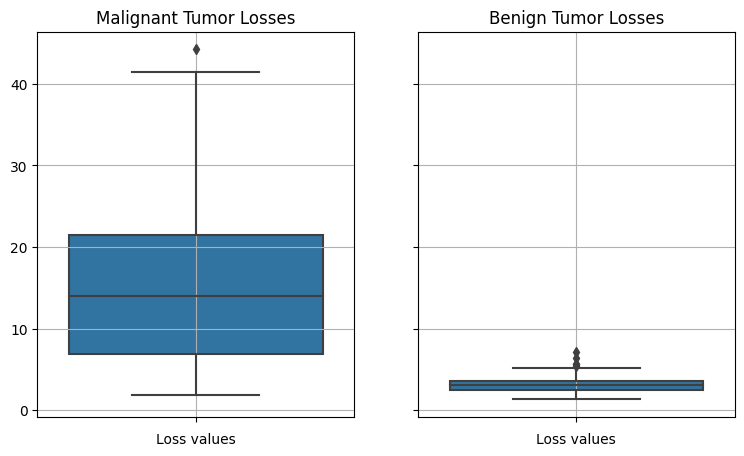

In [58]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(9, 5), sharey=True)
sns.boxplot(mal_pred_losses, ax=axs[0])
axs[0].set_title("Malignant Tumor Losses")
axs[0].set_xlabel('Loss values')
axs[0].set_xticklabels([])
axs[0].grid()
    
sns.boxplot(benign_pred_losses, ax=axs[1])
axs[1].set_title("Benign Tumor Losses")
axs[1].set_xlabel('Loss values')
axs[1].set_xticklabels([])
axs[1].grid()

In [59]:
fig.savefig('classical_loss_boxplots.png')